# Denoise Autoencoder

In [1]:
# import libs
import numpy as np
from keras.datasets import mnist

In [2]:
(X_train , _) ,(X_test, _) = mnist.load_data()
X_train.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(60000, 28, 28)

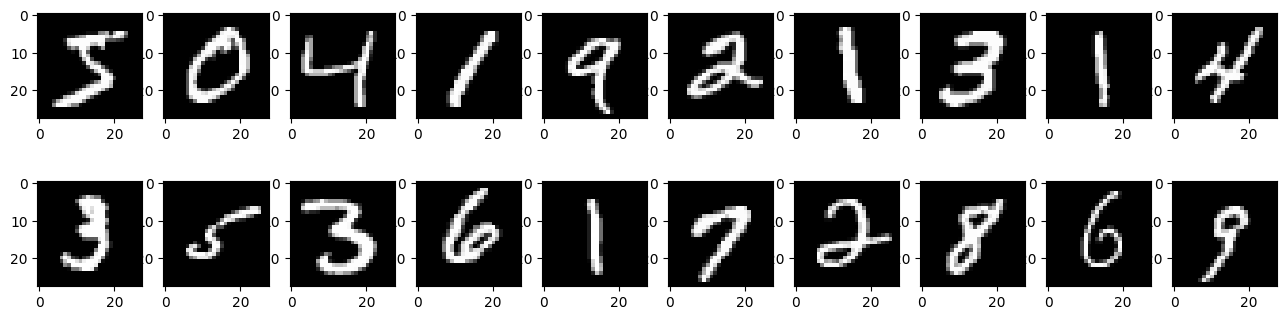

In [3]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2,10, figsize = (16, 4))

count = 0

for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train[count], cmap = 'gray')
        count+=1

## Normalize

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Add noise to images

In [6]:
# prepare source data
noise_factor = 0.1

X_train_noise = X_train + noise_factor * np.random.normal(loc = 0., scale = 1., size = X_train.shape)
X_test_noise = X_test + noise_factor * np.random.normal(loc = 0., scale = 1., size = X_test.shape)

In [7]:
X_train.shape

(60000, 28, 28)

## Visualize noisy data

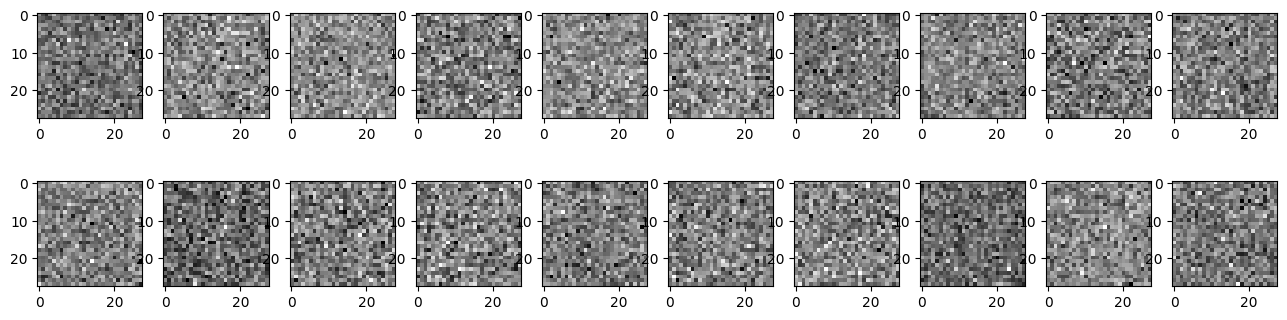

In [8]:
fig, axes = plt.subplots(2,10, figsize = (16,4))

count = 0
for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train_noise[count], cmap = 'gray')
        count+=1

# Reshape dataset

In [9]:
X_train = X_train.reshape(X_train.shape[0], 28 ,28, 1)
X_test = X_test.reshape(X_test.shape[0], 28,28,1)

X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 28 ,28, 1)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0], 28,28,1)

X_train.shape, X_train_noise.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

## Model

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

In [11]:
devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0], enable = True)

In [12]:
# encoder
encoder_input = Input(shape = X_train.shape[1:])
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D(pool_size = (2,2), padding = 'same')(x)

In [13]:
# decoder
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(x)

In [14]:
autoencoder = Model(encoder_input, decoded, name = 'Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,865 (112.75 KB)

 Trainable params: 28,609 (111.75 KB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

# Train the model

In [18]:
checkpoint = ModelCheckpoint("denoising_model.keras", save_best_only=True, save_weights_only=False, verbose = 1) # Changed the file extension to .keras
history = autoencoder.fit(X_train_noise, X_train, batch_size = 128, epochs = 50, callbacks = checkpoint, validation_split = 0.25, verbose = 2)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00620, saving model to denoising_model.keras
352/352 - 14s - 40ms/step - loss: 0.1159 - val_loss: 0.0062
Epoch 2/50

Epoch 2: val_loss improved from 0.00620 to 0.00428, saving model to denoising_model.keras
352/352 - 2s - 6ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 3/50

Epoch 3: val_loss improved from 0.00428 to 0.00410, saving model to denoising_model.keras
352/352 - 2s - 7ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 4/50

Epoch 4: val_loss improved from 0.00410 to 0.00403, saving model to denoising_model.keras
352/352 - 3s - 7ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 5/50

Epoch 5: val_loss improved from 0.00403 to 0.00400, saving model to denoising_model.keras
352/352 - 3s - 8ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/50

Epoch 6: val_loss improved from 0.00400 to 0.00399, saving model to denoising_model.keras
352/352 - 2s - 6ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/50

Epoch 7: val_loss improved fro

In [19]:
# load best performance model
from keras.models import load_model
autoencoder = load_model('denoising_model.h5')
autoencoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "Denoising_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_3 (InputLayer)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,867 (112.77 KB)

 Trainable params: 28,609 (111.75 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2 (12.00 B)

In [20]:
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28,28)
    count = 0
    fig, axes = plt.subplots(row, column, figsize = (16,4))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(data[count], cmap = 'gray')
            count+=1

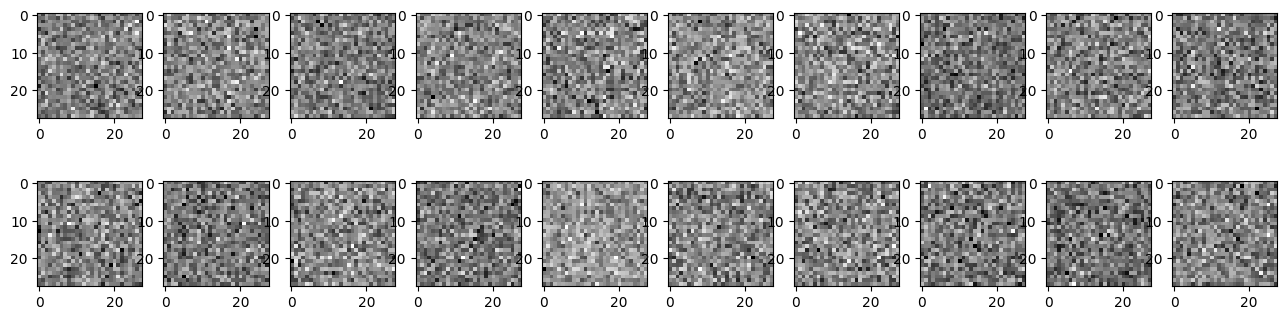

In [21]:
visualize_data(X_test_noise[:20], 2,10)

In [22]:
pred = autoencoder.predict(X_test_noise[:20])
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


(20, 28, 28, 1)

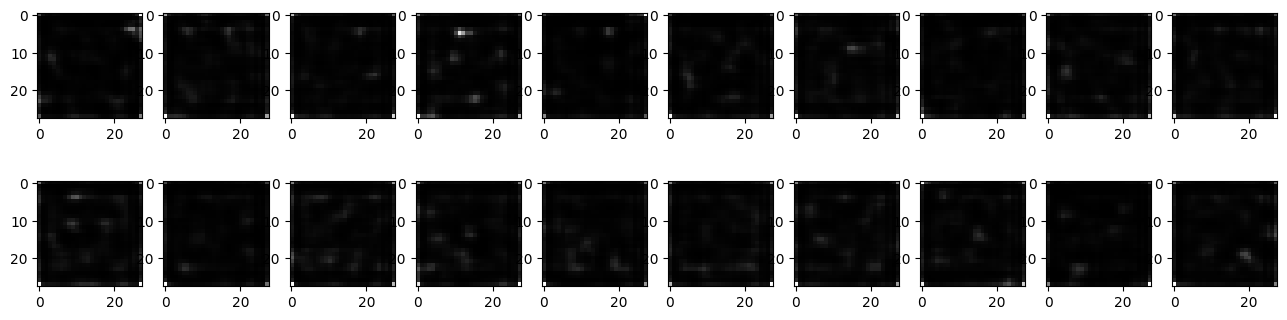

In [23]:
visualize_data(pred, 2, 10)